In [ ]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import os

# List of CSV files and their corresponding table names 
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),  # Added missing comma here
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Anshu shukla',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r"C:\Users\shukl\OneDrive\Desktop\Dashboard\Sql & Python e commerce data"  # Escaping backslashes

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Anshu shukla",
                            database = "ecommerce")

cur = db.cursor()

# List of all unique cities where customers are located

In [15]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [16]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 721616)

# Find the total sales per category

In [17]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,BED TABLE BATH,4.110129e+08
1,FASHION BAGS AND ACCESSORIES,5.235799e+07
2,MARKET PLACE,1.088062e+07
3,SPORT LEISURE,3.341106e+08
4,AUTOMOTIVE,2.045506e+08
...,...,...
69,FLOWERS,5.311224e+05
70,IMAGE IMPORT TABLETS,2.410303e+06
71,INSURANCE AND SERVICES,7.788240e+04
72,PC GAMER,5.218632e+05


# Calculate the percentage of orders that were paid in installments

In [18]:
query = """ select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is",data [0][0]


('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state

In [19]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1
0,SP,667936
1,SC,58192
2,MG,186160
3,PR,80720
4,RJ,205632
5,RS,87456
6,PA,15600
7,GO,32320
8,ES,32528
9,BA,54080


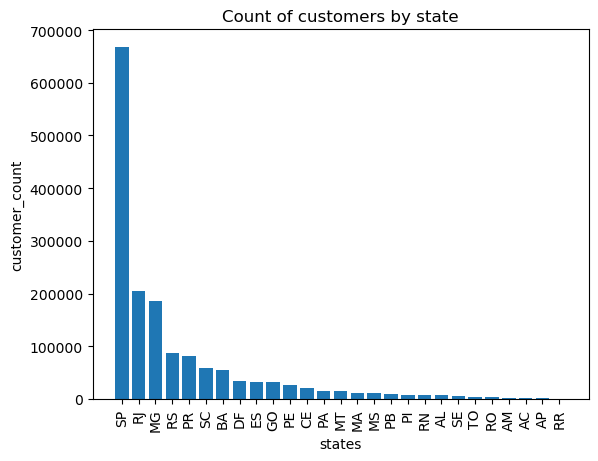

In [20]:
# Create chart
query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending=False)

plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of customers by state")
plt.show()

# Calculate the number of orders per month in 2018

In [21]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""
cur.execute(query)
data = cur.fetchall()
data

[('July', 100672),
 ('August', 104192),
 ('February', 107648),
 ('June', 98672),
 ('March', 115376),
 ('January', 116304),
 ('May', 109968),
 ('April', 111024),
 ('September', 256),
 ('October', 64)]

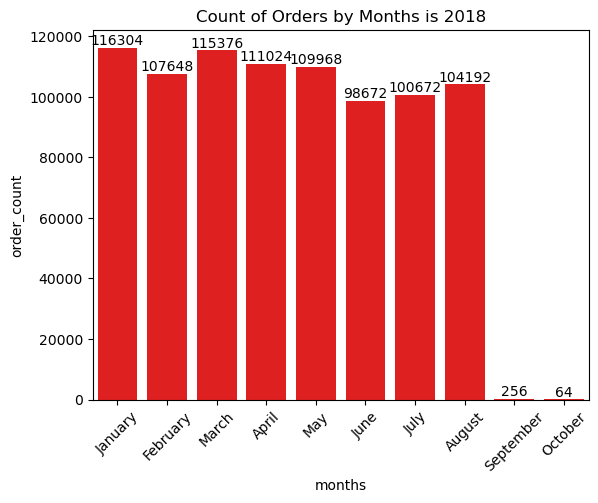

In [22]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city

In [23]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,448.00
1,celso ramos,416.00
2,datas,384.00
3,candido godoi,384.00
4,matias olimpio,320.00
5,cidelandia,256.00
6,curralinho,256.00
7,picarra,256.00
8,morro de sao paulo,256.00
9,teixeira soares,256.00


# Calculate the percentage of total revenue contributed by each product category

In [25]:
query = """
SELECT 
    UPPER(products.product_category) AS category,
    ROUND((SUM(order_items.price) / (SELECT SUM(price) FROM order_items)) * 100, 2) AS sales_percentage
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
GROUP BY 
    category 
ORDER BY 
    sales_percentage DESC;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Percentage Distribution"])
df.head()


,Category,Percentage Distribution
0,HEALTH BEAUTY,138.91
1,WATCHES PRESENT,132.99
2,BED TABLE BATH,114.44
3,SPORT LEISURE,109.04
4,COMPUTER ACCESSORIES,100.65


# Identify the correlation between product price and the number of times a product has been purchased

In [37]:
import numpy as np

quer = """ select products.product_category,
 count(order_items.product_id),
 round(avg(order_items.price),2)
 from products join order_items
 on products.product_id = order_items.product_id
 group by product.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157559


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [41]:
quer = """ (select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df

,seller_id,revenue,rank
0,sport leisure,518460,114.34
1,perfumery,205140,116.74
2,Furniture Decoration,500040,87.56
3,toys,247020,117.55
4,Cool Stuff,227760,167.36
...,...,...,...
69,Construction Tools Tools,6180,154.41
70,La Cuisine,840,146.78
71,Fashion Children's Clothing,480,71.23
72,insurance and services,120,141.64


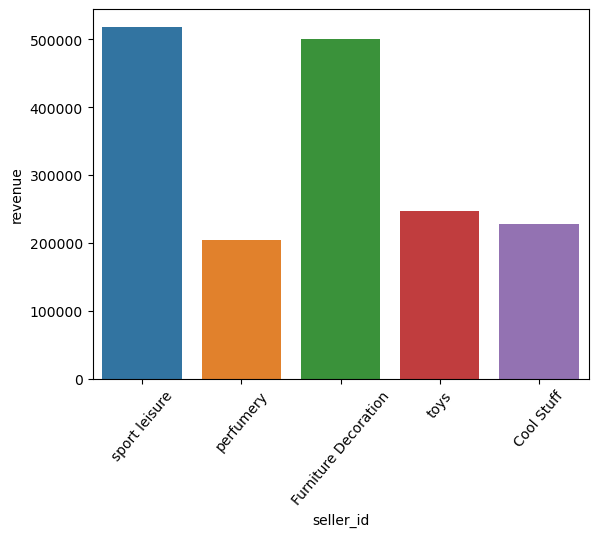

In [44]:
quer = """ (select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 50)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [47]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment)over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
6648699,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
6648700,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
6648701,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
6648702,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [48]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,16143.36,1.614336e+04
1,2016,10,3781790.72,3.797934e+06
2,2016,12,1255.68,3.799190e+06
3,2017,1,8863234.56,1.266242e+07
4,2017,2,18682112.61,3.134454e+07
5,2017,3,28791270.37,6.013581e+07
6,2017,4,26738433.89,8.687424e+07
7,2017,5,37946804.49,1.248210e+08
8,2017,6,32721688.34,1.575427e+08
9,2017,7,37912506.85,1.954552e+08


# Calculate the year-over-year growth rate of total sales

In [49]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [50]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year

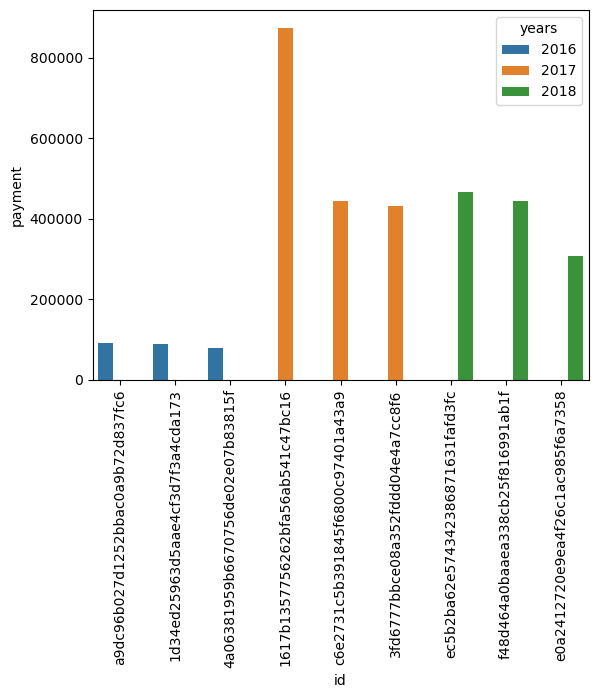

In [52]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()